# EE 511 Assignment 4 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [6]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import tools
import loadgalaxy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [3]:
imgs_train = loadgalaxy.LoadDir('galaxy/train')
imgs_val = loadgalaxy.LoadDir('galaxy/val')
imgs_test = loadgalaxy.LoadDir('galaxy/test')
print(imgs_train.shape)
print(imgs_val.shape)
print(imgs_test.shape)

(40872, 20, 20)
(10382, 20, 20)
(10324, 20, 20)


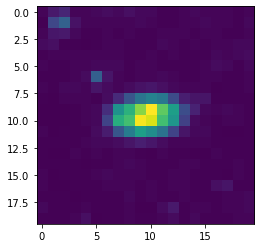

In [19]:
imgs_train = imgs_train.reshape(40872, 400)
imgs_val = imgs_val.reshape(10382, 400)
imgs_test = imgs_test.reshape(10324, 400)
imgplot = plt.imshow(imgs_train[0].reshape(20, 20))
plt.show()

## Play around with PCA

In [118]:
pca = PCA(n_components=25)
converted_val = pca.fit_transform(imgs_val)
inverted_val = pca.inverse_transform(converted_val)
converted_test = pca.fit_transform(imgs_test)
inverted_test = pca.inverse_transform(converted_test)

criterion = nn.MSELoss()
print('PCA MSE on validation: %.2f' % criterion(torch.Tensor(inverted_val), torch.Tensor(imgs_val)))
print('PCA MSE on testing: %.2f' % criterion(torch.Tensor(inverted_test), torch.Tensor(imgs_test)))

PCA MSE on validation: 37.39
PCA MSE on testing: 37.30


## Train an autoencoder

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(400, 100)
        self.fc2 = nn.Linear(100, 25)
        self.fc3 = nn.Linear(25, 100)
        self.fc4 = nn.Linear(100, 400)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x * 255

In [137]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 0.002
MOMENTUM = 0.5
SEED = 0
LOG_INTERVAL = 100

In [138]:
torch.manual_seed(SEED)
device = torch.device("cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count()) 
criterion = nn.MSELoss()

Using device cpu
num cpus: 4


In [139]:
data_train = torch.Tensor(imgs_train)
data_train = TensorDataset(data_train, data_train)
data_valid = torch.Tensor(imgs_val)
data_valid = TensorDataset(data_valid, data_valid)
data_test = torch.Tensor(imgs_test)
data_test = TensorDataset(data_test, data_test)

train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [140]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
tools.train(model, device, train_loader, optimizer, EPOCHS, LOG_INTERVAL, criterion, verbose=True)

Train Epoch: 0 [0/40872 (0%)]	Loss: 803.883789
Train Epoch: 0 [10000/40872 (24%)]	Loss: 111.968552
Train Epoch: 0 [20000/40872 (49%)]	Loss: 107.682884
Train Epoch: 0 [30000/40872 (73%)]	Loss: 115.874496
Train Epoch: 0 [40000/40872 (98%)]	Loss: 92.735947
Train Epoch: 1 [0/40872 (0%)]	Loss: 85.359451
Train Epoch: 1 [10000/40872 (24%)]	Loss: 103.916641
Train Epoch: 1 [20000/40872 (49%)]	Loss: 92.647339
Train Epoch: 1 [30000/40872 (73%)]	Loss: 97.284416
Train Epoch: 1 [40000/40872 (98%)]	Loss: 76.381142
Train Epoch: 2 [0/40872 (0%)]	Loss: 115.528610
Train Epoch: 2 [10000/40872 (24%)]	Loss: 84.812706
Train Epoch: 2 [20000/40872 (49%)]	Loss: 87.763359
Train Epoch: 2 [30000/40872 (73%)]	Loss: 102.309784
Train Epoch: 2 [40000/40872 (98%)]	Loss: 71.550003
Train Epoch: 3 [0/40872 (0%)]	Loss: 64.861923
Train Epoch: 3 [10000/40872 (24%)]	Loss: 91.610916
Train Epoch: 3 [20000/40872 (49%)]	Loss: 91.888191
Train Epoch: 3 [30000/40872 (73%)]	Loss: 114.727165
Train Epoch: 3 [40000/40872 (98%)]	Loss: 10

In [142]:
loss = 0
for im in imgs_val:
    im_tensor = torch.Tensor(im)
    ouput = model(im_tensor)
    loss += criterion(ouput, im_tensor)
print('Total MSE loss on validation data: %.2f' % (loss/len(imgs_val)))

Total MSE loss on validation data: 48.27


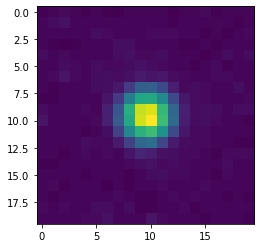

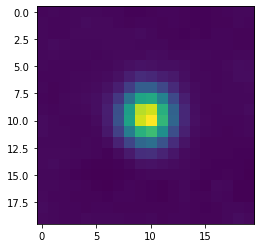

In [143]:
ouput = model(torch.Tensor(imgs_val[0]))
imgplot = plt.imshow(imgs_val[0].reshape(20, 20))
plt.show()
imgplot = plt.imshow(ouput.data.reshape(20, 20))
plt.show()